# Number of Equilibria

In [148]:
import numpy as np
import pandas as pd
import scipy.stats as scs
import helperfuns
from helperfuns import *
from numpy.lib.scimath import sqrt as csqrt
import matplotlib as mpl
import matplotlib.pyplot as plt

fig_directory = '/Users/taliaborofsky/Documents/Stanford/Research/Feldman/Ecology_of_Learning/Pop Dynamics Social Learning/TeX_PopDyn/Figures_NoDelay'

In [184]:
%%writefile equilibriumfuns.py

import numpy as np
import pandas as pd
import scipy.stats as scs
import helperfuns
from helperfuns import *
from numpy.lib.scimath import sqrt as csqrt



def get_r_hat(K,pc,delta,R):
    a = pc + K*(delta-R)/(1+delta)
    b = (delta-R)*(K*(1+R)/(1+delta)-1) - R*pc
    c = -R*(delta-R)*(1 - K/(1+delta))
    
    
    discrim = b**2 - 4*a*c
    rpos = 0
    rneg = 0
    if discrim >= 0:
        rpos = (-b + np.sqrt(b**2 - 4*a*c))/(2*a) 
        rneg = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
        if R < delta:
            rpos_ans = rpos if rpos > 0 and rpos >= delta else np.nan
            rneg_ans=np.nan
        if R > delta:
            rpos_ans = rpos if rpos > 0 and rpos <= delta else np.nan
            rneg_ans = rneg if rneg > 0 and rneg <= delta else np.nan
        if R== delta:
            rpos_ans = R if R > 0 else np.nan
            rneg_ans = np.nan
    else:
        rpos_ans = np.nan
        rneg_ans = np.nan

    return(np.array([rpos_ans,rneg_ans]))
# Finds the nonzero r equilibrium if it exists
# inputs must be arrays with the same dimensions
def get_r_hat_v(K, pc, delta, R):
    
    K,pc,delta,R = [np.array(item) for item in [K,pc,delta,R]]
    #rpos = np.zeros(K.shape)
    #rneg = np.zeros(K.shape)
    
    a = pc + K*(delta-R)/(1+delta)
    b = (delta-R)*(K*(1+R)/(1+delta)-1) - R*pc
    c = -R*(delta-R)*(1 - K/(1+delta))
    discrim = b**2 - 4*a*c
    
    rpos = np.array((-b + csqrt(b**2 - 4*a*c))/(2*a))
    rneg = (-b - csqrt(b**2 - 4*a*c))/(2*a)
    
    rpos_ans = np.zeros(rpos.shape)
    rneg_ans = np.zeros(rneg.shape)
    
    mask1a = ((discrim>=0) & (rpos >0))& ((rpos <=delta)& (R>delta))
    mask1b = ((discrim>=0) & (rpos >0))& ((rpos >=delta)& (R<delta))
    rpos_ans[mask1a] = rpos[mask1a].real # these are real numbers anyways with 0 in the imaginary part, 
    # but this gets rid of the complex casting warning
    rpos_ans[mask1b] = rpos[mask1b].real
    
    mask2a = ((discrim>=0) & (rneg >0))& ((rneg <=delta)&(R>delta))
    mask2b = ((discrim>=0) & (rneg >0))& ((rneg >=delta)&(R<delta))
    rneg_ans[mask2a]=rneg[mask2a].real 
    rneg_ans[mask2b]=rneg[mask2b].real
    
    
    return(rpos_ans, rneg_ans)
# Finds the u_r equilibrium for the r that solves r = 1 - beta*N*L, if it exists
# works if delta \neq R
def get_u_hat(r,delta,R):
    # note need r > 0\ 
    if r==R:
        print('we have a problem. r = R.')
        # either N_p = 0 or R = delta
        if R == delta:
            return(np.nan)
    if R == delta:
        print('we have a problem. R = delta.')
    W = 1 + R + (r-R)
    L = (delta-R)/(r-R)
    u_r = L*(1+r)/(1+delta)
    
    return(u_r)

def get_N_hat(r,delta,R,beta):
    N = (1-r)*(r-R)/(beta*(delta-R))
    return(N)

# this should be 1 + delta if r > 0
#def get_W_hat(r,delta,R)

def get_Jstar_lambdas(r,u,N,K,pc,delta,R):
    # J = ((1,a,b), (0,c,d), (e,f,g))
    # rows and columns: dn, du, dr
    #(1,a,b) from Eq. 37 (the equation for delta_N')
    # (0,c,d) from Eq. 38 (the equation for delta_u_r')
    # (e,f,g) from Eq. 39 (the equation for delta_r')
    L = K*u + pc*r/(r+R)
    a = N*K
    b = N*(L + R*pc*(r-R)/((r+R)**2))
    c = (K/(1+delta))*(1+r-u*(r-R))
    d = (L/(1+delta))*(1-u) + (pc*R/((1+delta)*(r+R)**2))*(1+r-u*(r-R))
    e = -r*beta*L/(1+r)
    f = -K*N*r*beta/(1+r)
    g = 1/(1+r) - N*r*beta*R*pc/((1+r)*(r+R)**2)
    
    xi1 = -c -g -1
    xi2 = b*e - c*g - c + d*f - g
    xi3 = -a*d*e + b*c*e - c*g + d*f
    xi4 = np.sqrt(-4*(3*xi2 + xi1**2)**3 + (27*xi3 + 9*xi1*xi2 + 2*xi1**3)**2)
    xi5 = np.cbrt((27/2)*xi3 + (1/2)*xi4 + (9/2)*xi1*xi2 + xi1**3)
    lambda1 = (-1/3)*(xi1 + (3*xi2 + xi1**2)/xi5 + xi5)

    vcomplex = np.vectorize(complex)
    lambda2 = vcomplex((1/3)*(xi1 + (3*xi2+xi1**2)/(2*xi5) + xi5/2),
                                   (np.sqrt(3)/6)*((3*xi2+xi1**2)/xi5 - xi5))
    lambda3 = vcomplex((1/3)*(xi1 + (3*xi2+xi1**2)/(2*xi5) + xi5/2),
                                   -(np.sqrt(3)/6)*((3*xi2+xi1**2)/xi5 - xi5))
    
    return([lambda1, lambda2, lambda3])

# gets the internal stability given parameters and r
def get_internal_stability(r,beta,K,pc,delta,R):
    if r == np.nan:
        return(np.nan)
    N = get_N_hat(r,delta,R,beta)
    #TO-DO: What if delta = R???
    u = get_u_hat(r,delta,R)
    lambdas = get_Jstar_lambdas(r,u,N,K,pc,delta,R)
    mags = np.abs(lambdas)
    if np.max(mags)>1:
        return(0)
    elif np.max(mags) < 1:
        return(1)
    else:
        return(-1)



Writing equilibriumfuns.py


In [57]:
np.isnan(np.nan)

True

In [77]:
np.arange(0,1,0.2)

array([0. , 0.2, 0.4, 0.6, 0.8])

In [118]:
np.tile([0,1],2)

array([0, 1, 0, 1])

In [127]:
str(1)

'1'

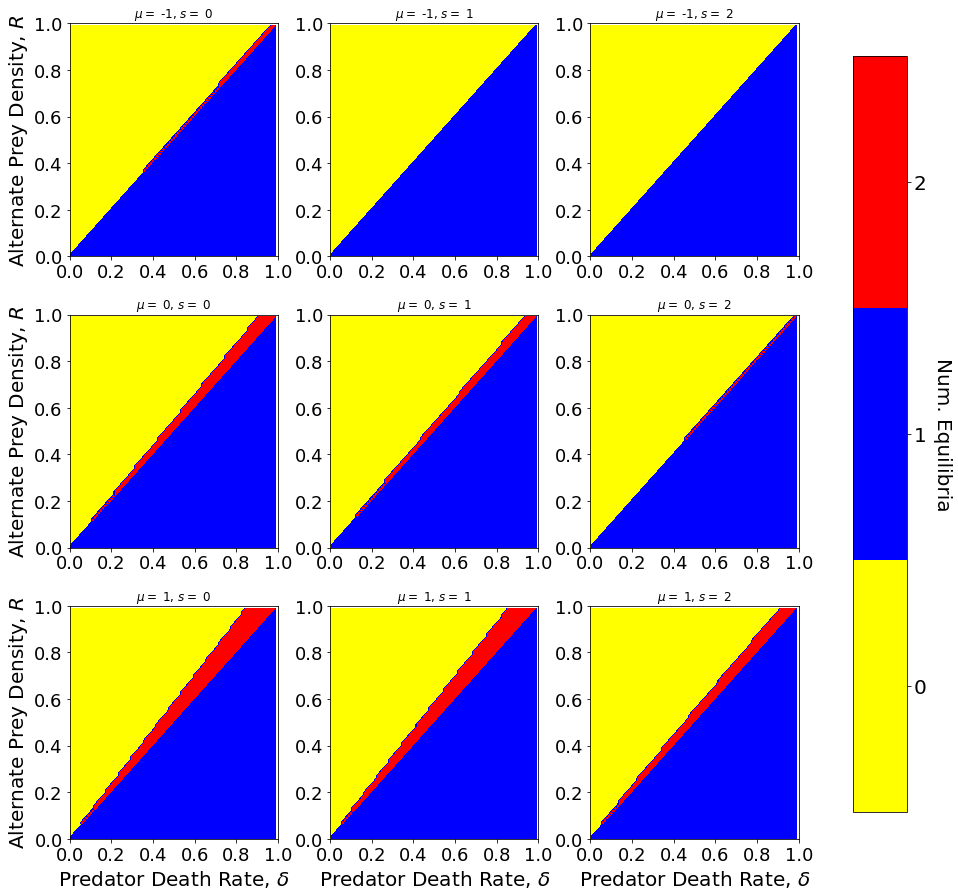

In [128]:
deltavals = np.arange(0,1,0.01)
Rvals = np.arange(0,1,0.01)

muvals = np.repeat([-1,0,1],3)
svals = np.tile([0,1,2],3)


# make parameter grid of delta and R

deltamesh, Rmesh = np.meshgrid(deltavals, Rvals)

# set up figure
fig, axes = plt.subplots(3,3, figsize = (15,15))

# vectorized functions
get_r_hat_vec = np.frompyfunc(get_r_hat,4,1)
numr = lambda r: sum(~np.isnan(r))
vnumr = np.vectorize(numr)

for i,ax in enumerate(axes.flatten()):
    mu = muvals[i]
    s = svals[i]
    K = Kfun(s,scs.norm(mu))
    pc = pcfun(s,scs.norm(mu))
    
    # for each (delta, R), find out the number of nonzero r hats. use np.isnan(). This is the contour

    out = get_r_hat_vec(K, pc, deltamesh, Rmesh)
    numr_mat = vnumr(out)

    # plot as contour plot
    cp = ax.contourf(deltamesh,Rmesh, numr_mat, levels = [-0.5,0.5,1.5,2.5], colors = ['yellow','blue','red'])

    # make ticks nice

    ax.set_xticks(ticks = np.arange(0,1.2,0.2))
    ax.set_yticks(ticks = np.arange(0,1.2,0.2))
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.set_title(r'$\mu=$ '+ str(mu) +r', $s = $ ' + str(s))
    # label axes
    if i in [6,7,8]:
        ax.set_xlabel(r'Predator Death Rate, $\delta$', fontsize=20)
    if i in [0,3,6]:
        ax.set_ylabel(r'Alternate Prey Density, $R$', fontsize=20)

# colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85,0.15,0.05,0.7])
cb = fig.colorbar(cp, cax = cbar_ax)
cb.ax.get_yaxis().set_ticks([0,1,2])
cb.ax.set_yticklabels([0,1,2], fontsize = 20)
cb.ax.set_ylabel(r'Num. Equilibria',rotation=-90, fontsize = 20, labelpad = 25)

fig.subplots_adjust(hspace=0.25,wspace = 0.25) # for if I have multiple plots


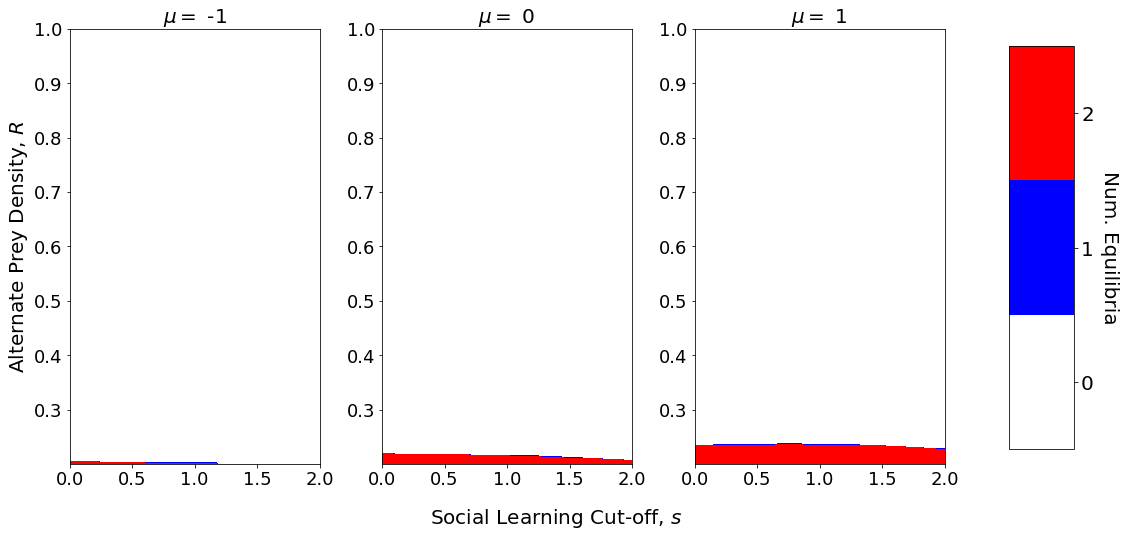

In [181]:
delta = 0.2
muvals = [-1,0,1]



Rvals = np.linspace(delta+0.001,1,500)
svals = np.linspace(0,2,100)




# make parameter grid of delta and R

smesh, Rmesh = np.meshgrid(svals, Rvals)

# set up figure
fig, axes = plt.subplots(1,3, figsize = (18,8))

# vectorized functions
get_r_hat_vec = np.frompyfunc(get_r_hat,4,1)
numr = lambda r: sum(~np.isnan(r))
vnumr = np.vectorize(numr)

for i,ax in enumerate(axes.flatten()):
    mu = muvals[i]
    
    K = Kfun(smesh,scs.norm(mu))
    pc = pcfun(smesh,scs.norm(mu))
    
    # for each (delta, R), find out the number of nonzero r hats. use np.isnan(). This is the contour

    out = get_r_hat_vec(K, pc, delta, Rmesh)
    numr_mat = vnumr(out)

    # plot as contour plot
    cp = ax.contourf(smesh,Rmesh, numr_mat, levels = [-0.5,0.5,1.5,2.5], colors = ['white','blue','red'])

    # make ticks nice

    #ax.set_xticks(ticks = np.arange(0,1.2,0.2))
    #ax.set_yticks(ticks = np.arange(0,1.2,0.2))
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.set_title(r'$\mu=$ '+ str(mu), fontsize = 20)

    if i in [0,3,6]:
        ax.set_ylabel(r'Alternate Prey Density, $R$', fontsize=20)

fig.supxlabel(r'Social Learning Cut-off, $s$', fontsize = 20)

        

# colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85,0.15,0.05,0.7])
cb = fig.colorbar(cp, cax = cbar_ax)
cb.ax.get_yaxis().set_ticks([0,1,2])
cb.ax.set_yticklabels([0,1,2], fontsize = 20)
cb.ax.set_ylabel(r'Num. Equilibria',rotation=-90, fontsize = 20, labelpad = 25)

fig.subplots_adjust(hspace=0.25,wspace = 0.25) # for if I have multiple plots
fig.savefig(fig_directory + '/NumEquilibria_Rversuss_delta02_big.eps')

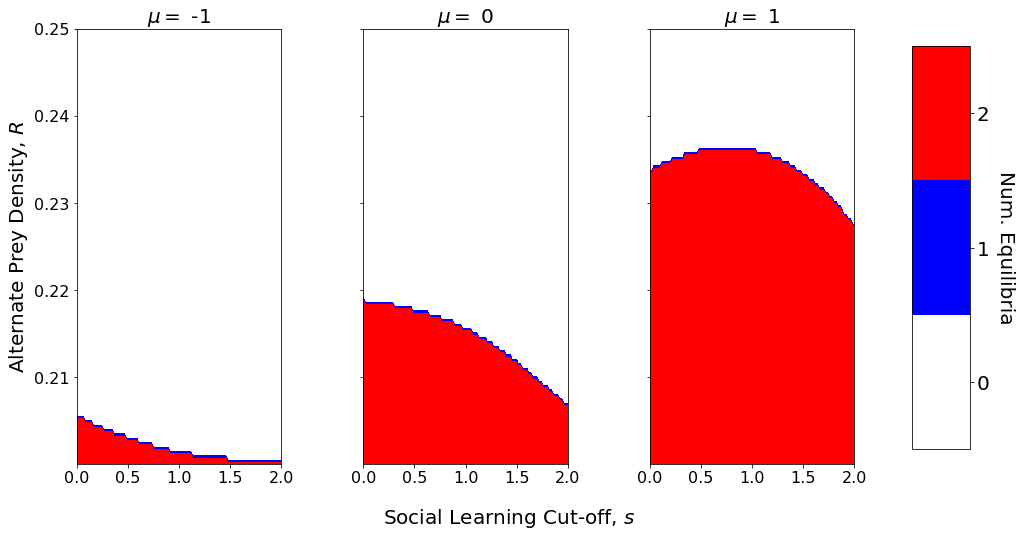

In [182]:
delta = 0.2
muvals = [-1,0,1]



Rvals = np.linspace(delta+0.0001,delta+0.05,100)
svals = np.linspace(0,2,100)




# make parameter grid of delta and R

smesh, Rmesh = np.meshgrid(svals, Rvals)

# set up figure
fig, axes = plt.subplots(1,3, figsize = (16,8),sharex=True, sharey=True)

# vectorized functions
get_r_hat_vec = np.frompyfunc(get_r_hat,4,1)
numr = lambda r: sum(~np.isnan(r))
vnumr = np.vectorize(numr)


for i,ax in enumerate(axes.flatten()):
    mu = muvals[i]
    
    K = Kfun(smesh,scs.norm(mu))
    pc = pcfun(smesh,scs.norm(mu))
    
    # for each (delta, R), find out the number of nonzero r hats. use np.isnan(). This is the contour

    out = get_r_hat_vec(K, pc, delta, Rmesh)
    numr_mat = vnumr(out)

    # plot as contour plot
    cp = ax.contourf(smesh,Rmesh, numr_mat, levels = [-0.5,0.5,1.5,2.5], colors = ['white','blue','red'])

    # make ticks nice

    #ax.set_xticks(ticks = np.arange(0,1.2,0.2))
    #ax.set_yticks(ticks = np.arange(0,1.2,0.2))
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_title(r'$\mu=$ '+ str(mu), fontsize = 20)
    # label axes
    
    #ax.set_xlabel(r'Social Learning Cut-off, $s$', fontsize=20, labelpad = 15)
    if i == 0:
        ax.set_ylabel(r'Alternate Prey Density, $R$', fontsize=20)
    #ax.get_xaxis().labelpad=15

    
fig.supxlabel(r'Social Learning Cut-off, $s$', fontsize = 20)


# colorbar

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85,0.15,0.05,0.7])
cb = fig.colorbar(cp, cax = cbar_ax)
cb.ax.get_yaxis().set_ticks([0,1,2])
cb.ax.set_yticklabels([0,1,2], fontsize = 20)
cb.ax.set_ylabel(r'Num. Equilibria',rotation=-90, fontsize = 20, labelpad = 25)

fig.subplots_adjust(hspace=0.25,wspace = 0.4) # for if I have multiple plots

fig.savefig(fig_directory + '/NumEquilibria_Rversuss_delta02_close.eps')

In [79]:
f = np.vectorize(complex)
[1,f(1,2),2]

[1, array(1.+2.j), 2]

In [6]:
delta = 0.3
R = 0.7
K = 0
pc = 1
Q_r_delta = delta*(delta-R)*((K/(1+delta))*(delta+R) + pc - (1+R)*(1-K/(1+delta)))

In [7]:
get_r_hat(K,pc,delta,R)

[0, 0]

In [15]:
mu = np.array([-1,0,1])
s = np.append(np.linspace(0,1,5),[2,3])
delta = 0.2
R = [0.21, 0.3, 0.5, 0.8]

mu_mat, s_mat, delta_mat, R_mat = np.meshgrid(mu, s, delta, R)
mu_vec, s_vec, delta_vec, R_vec = [np.ndarray.flatten(vec) for vec in [mu_mat, s_mat, delta_mat, R_mat]]
norms = scs.norm(mu_vec)
K = Kfun(s_vec,norms)
pc = pcfun(s_vec,norms)

TypeError: oct() takes exactly one argument (2 given)

In [134]:
rhat1, rhat2 = get_r_hat_v(K, pc, delta_vec, R_vec)

In [39]:
get_r_hat_vec = np.frompyfunc(get_r_hat,4,1)

In [40]:
get_r_hat_vec

<ufunc 'get_r_hat (vectorized)'>

In [41]:
out = get_r_hat_vec(K, pc, delta_vec, R_vec)

In [168]:
df = pd.DataFrame(data={'K':K, 'pc':pc, 'mu': mu_vec, 's': s_vec, 'delta':delta_vec, 
                        'R': R_vec, 'rhat_1':rhat1, 'rhat_2':rhat2})

In [147]:
mu = 0; s = 0.5; delta = 0.2




In [181]:
np.vectorize(get_internal_stability)(rhat1,beta,K,pc,delta,R) 

ZeroDivisionError: float division by zero

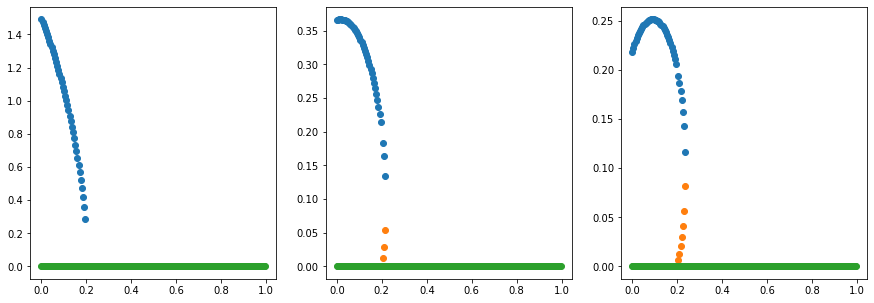

In [22]:
fig,axs= plt.subplots(1,3, figsize=(15,5) )
mu = -1
s = 0.5
delta = 0.2
R = np.arange(0,1,0.005)
for i, ax in enumerate(axs):
    K = Kfun(s,scs.norm(mu))
    pc = pcfun(s,scs.norm(mu))
    rhat1, rhat2 = get_r_hat_v(K,pc,delta,R)
    rhat1[rhat1==0]=np.nan
    rhat2[rhat2==0]=np.nan
    rhat3 = np.zeros(rhat1.shape)
    #stability1 = np.vectorize(get_internal_stability)(rhat1,beta,K,pc,delta,R)
    #stability2 = get_internal_stability(rhat2,beta,K,pc,delta,R)
    #stability3 = get_internal_stability(rhat2,beta,K,pc,delta,R)
    ax.scatter(R,rhat1)
    ax.scatter(R,rhat2)
    ax.scatter(R,rhat3)
    mu = mu + 1

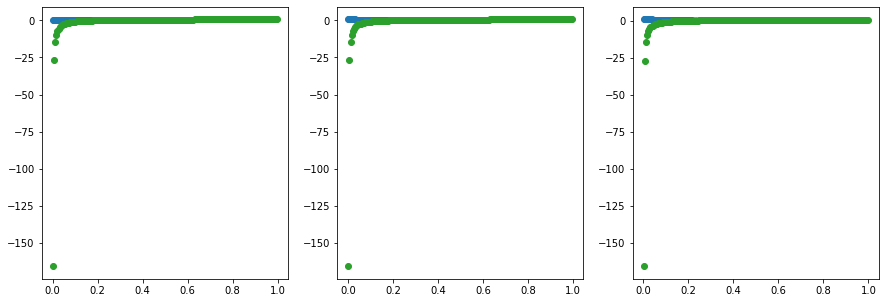

In [171]:
fig,axs= plt.subplots(1,3, figsize=(15,5) )
mu = -1
s = 0.5
delta = 0.2
R = np.arange(0.001,1,0.005)
for i, ax in enumerate(axs):
    K = Kfun(s,scs.norm(mu))
    pc = pcfun(s,scs.norm(mu))
    rhat1, rhat2 = get_r_hat_v(K,pc,delta,R)
    rhat1[rhat1==0]=np.nan
    rhat2[rhat2==0]=np.nan
    uhat1 = np.vectorize(get_u_hat)(rhat1,delta,R)
    uhat2 = np.vectorize(get_u_hat)(rhat2,delta,R)
    #uhat3 = np.vectorize(get_u_hat)(0,delta,R)
    
    #stability1 = get_internal_stability(rhat1,beta,K,pc,delta,R)
    #stability2 = get_internal_stability(rhat2,beta,K,pc,delta,R)
    #stability3 = get_internal_stability(rhat2,beta,K,pc,delta,R)
    ax.scatter(R,uhat1)
    ax.scatter(R,uhat2)
    mu = mu + 1

array([1.70622318, 1.76022615, 1.81226262, 1.86355491, 1.91500991,
       1.9673631 , 2.02126036, 2.07731037, 2.13612319, 2.19834318,
       2.26468165, 2.33595383, 2.4131251 , 2.49737333, 2.5901778 ,
       2.69345277, 2.80975777, 2.94264767, 3.09729383, 3.28168044,
              nan, 3.80499687, 4.22719844, 4.98229119,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        

In [102]:
u = np.array(uhat1)
r=np.array(rhat1)
N= np.array(Nhat1)
#f = np.vectorize(get_internal_stability)
np.vectorize(get_Jstar_lambdas)(r,u,N,K,pc,delta,R)

array([0.20412447, 0.2068487 , 0.20988996, 0.2131478 , 0.21656763,
       0.22012049, 0.22379333, 0.22758413, 0.23149962, 0.23555445,
       0.23977155, 0.24418345, 0.24883478, 0.25378656, 0.25912303,
       0.26496312, 0.27148012, 0.27893792, 0.2877627 , 0.2987019 ,
              nan, 0.33495015, 0.37714202, 0.82142361,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        

In [97]:
get_Jstar_lambdas(r[0],u[0],N[0],K,pc,delta,R[0])

[(0.20412447014742946+0j),
 (-0.4396206171793241-0.3500715739763635j),
 (-0.4396206171793241+0.3500715739763635j)]